In [3]:
import cv2
import numpy as np
from cv2 import aruco
import matplotlib.pyplot as plt
import pyrealsense2 as rs
import json

Set up camera and retrieve intrinsics info

In [4]:
config = rs.config()
pipeline = rs.pipeline()
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))


In [5]:
rgb_available = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        rgb_available = True
        break
if not rgb_available:
    exit(0)

In [6]:
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)



In [7]:
profile = pipeline.start(config)

In [8]:
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
intrinsics = rs.video_stream_profile(profile.get_stream(rs.stream.color)).get_intrinsics()
print(depth_scale, intrinsics)

9.999999747378752e-05 [ 640x480  p[318.766 241.985]  f[609.116 608.212]  Inverse Brown Conrady [0 0 0 0 0] ]


In [9]:
print(intrinsics.ppy)

241.9846649169922


In [10]:
def compose_intrinsic_matrix(intrinsics, export_distort=False):
    if not export_distort:
        return np.array([[intrinsics.fx, 0, intrinsics.ppx],
                         [0, intrinsics.fy, intrinsics.ppy],
                         [0, 0, 1]])
    else:
        return np.array([[intrinsics.fx, 0, intrinsics.ppx],
                         [0, intrinsics.fy, intrinsics.ppy],
                         [0, 0, 1]]), intrinsics.coeffs


In [12]:
cam_mtx, coeff = compose_intrinsic_matrix(intrinsics, export_distort=True)
print(cam_mtx, coeff)

[[609.11572266   0.         318.76638794]
 [  0.         608.21179199 241.98466492]
 [  0.           0.           1.        ]] [0.0, 0.0, 0.0, 0.0, 0.0]


In [13]:
align_to = rs.stream.color
align = rs.align(align_to)

Configuring depth sensor

In [14]:
import json

In [16]:
file = open("/home/nguyen/uni/cv/realsense/demo_calib/data/config_realsense.json", "r")
as_json_object = json.load(file)

    # We can also load controls from a json string
    # For Python 2, the values in 'as_json_object' dict need to be converted from unicode object to utf-8
if type(next(iter(as_json_object))) != str:
    as_json_object = {k.encode('utf-8'): v.encode("utf-8") for k, v in as_json_object.items()}
# print(as_json_object)
json_string = str(as_json_object).replace("'", '\"')

In [17]:
depth_sensor, color_sensor = profile.get_device().query_sensors()
dev = profile.get_device()
adv_mode = rs.rs400_advanced_mode(dev)
adv_mode.load_json(json_string)

In [22]:
pipeline.start()

Grab frame

In [23]:
frame = pipeline.wait_for_frames()
aligned_frame = align.process(frame)
depth_frame = np.array(aligned_frame.get_depth_frame().get_data())
color_frame = np.array(aligned_frame.get_color_frame().get_data())[:, :, ::-1]
# plt.imshow(color_frame)
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(121)
ax1.imshow(color_frame[:, :, ::-1])
ax2 = plt.subplot(122)
ax2.imshow(depth_frame, cmap='plasma')

RuntimeError: Frame didn't arrive within 5000

In [61]:
temp_filter = rs.temporal_filter(0.1, 80, 6)
spat_filter = rs.spatial_filter(0.4, 40, 4, 1)
hole_filter = rs.hole_filling_filter(0)

In [62]:
depth_frame = aligned_frame.get_depth_frame()
depth_frame = rs.disparity_transform(True).process(depth_frame)
depth_frame = spat_filter.process(depth_frame)
depth_frame = temp_filter.process(depth_frame)
depth_frame = hole_filter.process(depth_frame)
depth_frame = rs.disparity_transform(False).process(depth_frame)

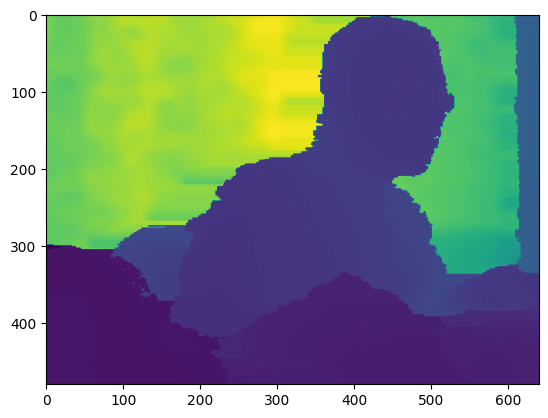

In [64]:
img = np.array(depth_frame.get_data())
plt.imshow(img)

In [24]:
pipeline.stop()